In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2
from process_results import process_results

import style
cb = '#33ccff'

In [2]:
style.set_style()

# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/lay1_big_lrs'
fnames = sorted([fname for fname in os.listdir(out_dir) ])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()
    
# print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 51/51 [00:00<00:00, 149.61it/s]


# add cols

In [4]:
# adds these vec keys: fc0_fro, fc1_fro, fc0_stab_rank, fc1_stab_rank, act0_stab_rank, act1_stab_rank, corr0, corr1
# adds these scalar keys: max_train_acc, max_test_acc, _final of all the above
its, ts, results = process_results(results)
print(results.shape)

(17, 77)


# plot max corrs
*note some things disappear in below plot as a result of nans*

(0, 1)

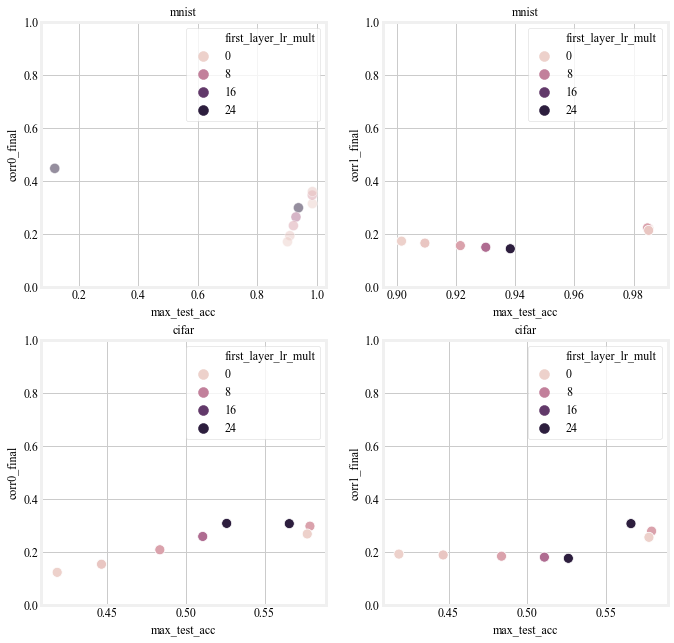

In [5]:
r = results[results.seed == 0]
# r = results[results.num_layers == 4]
# print(r[['lr', 'first_layer_lr_mult', 'corr0_final']])
hue = 'first_layer_lr_mult'

plt.figure(figsize=(10, 10), facecolor='w')
R, C = 2, 2
rm = r[r.dset == 'mnist']
# rm = rm[rm.max_test_acc > 0.9]
plt.subplot(R, C, 1)
plt.title('mnist')

sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue], alpha=0.5)
plt.ylim(0, 1)

plt.subplot(R, C, 2)
plt.title('mnist')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)


rm = r[r.dset == 'cifar10']
# rm = rm[rm.max_test_acc > 0.4]
plt.subplot(R, C, 3)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 4)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)

# track things over time

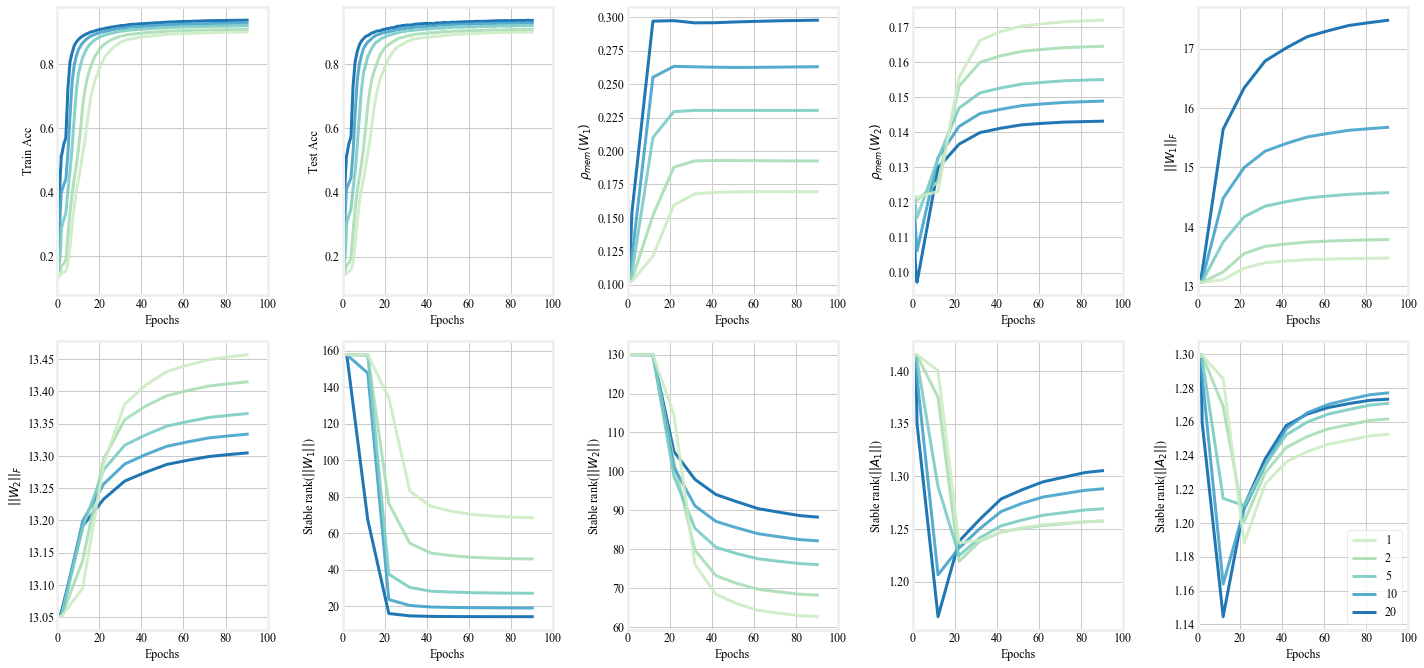

In [16]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

r = results
# sweep_params = ['lr', 'optimizer', 'num_layers', 'dset', 'batch_size', 'shuffle_labels', 'hidden_size']# wanna group by everything but seed

# r = r[r.max_train_acc < 0.9]
# r = r.groupby(sweep_params)
# r = r.filter(lambda x: len(x) > 5) # groups must contain at least 6 runs
# r = r.groupby(sweep_params).mean().reset_index()
# print(r.dset)
# r = r[(r.dset == 'mnist')]
# r = r[(r.dset == 'mnist') * (r.max_test_acc > 0.95)] # good mnist
r = r[(r.dset == 'mnist') * (r.max_test_acc < 0.95) * (r.max_test_acc > 0.5)] # okay mnist
# rm = results[(results.dset == 'mnist') * (results.max_test_acc < 0.9) * (results.seed==0)] # bad mnist
# r = r[(r.dset == 'cifar10') * (r.max_test_acc <= 0.55) * (r.seed==0)] # okay cifar10
# rm = results[(results.dset == 'cifar10') * (results.max_test_acc < 0.4) * (results.seed==0)] # good cifar10
R, C = 2, 5
plt.figure(figsize=(20, 9.5), facecolor='w')
xlim = 100
cs_5 = {1: '#ccebc5', 2: '#a8ddb5', 5: '#7bccc4', 10: '#43a2ca', 20: '#0868ac'}
vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']
val_labs = ['Train Acc', 'Test Acc', '$\\rho_{mem}(W_1)$', '$\\rho_{mem}(W_2)$', 
        '$||W_1||_F$', '$||W_2||_F$', 'Stable rank($||W_1||$)', 'Stable rank($||W_2||$)', 'Stable rank($||A_1||$)', 'Stable rank($||A_2||$)']

# well-behaved
for j, (_, row) in enumerate(r.iterrows()):

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
        try:
            plt.plot(ts, row[val], color=cs_5[row.first_layer_lr_mult], label=row.first_layer_lr_mult, alpha=0.9)
        except:
            plt.plot(row.its[:row[val].size], row[val], color=cs_5[row.first_layer_lr_mult], label=row.first_layer_lr_mult, alpha=0.9)
        plt.xlabel('Epochs')
        plt.ylabel(val_labs[i])
        plt.xlim((0, xlim))
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
keys = ['1', '2', '5', '10', '20']
vals = [by_label[key] for key in keys]
plt.legend(vals, keys)
plt.tight_layout()
plt.savefig('lay1_large.pdf')